In [1]:
"""Scripts for analyzing of phantom outputs.

This script generate lightcurves (LC) by doing radiative transfer on a grid.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script generate lightcurves (LC) by doing radiative transfer on a grid.\n\n'

.

# Def

.

## Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from datetime import datetime
#from moviepy.editor import ImageSequenceClip
#from os import path

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos
from clmuphantomlib.log        import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib.light      import get_optical_depth_by_ray_tracing_3D, get_photosphere_on_ray

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_LCGen__input import verbose, interm_dir, output_dir, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting light curves by intergrating across a grid of rays"
metadata['Description'] = f"""Getting light curves by intergrating across a grid of rays with the same directions
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos_base import EoS_Base
from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
import numba
from numba import jit, prange
import sarracen

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

## Functions

In [6]:
# load from matin script

# backup-ed old codes
from script_LCGen import integrate_along_ray, integrate_error_along_ray
# test codes (alpha)
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis_test
# actual code
from script_LCGen import _integrate_along_ray_gridxy_sub_parallel_analysis, _integrate_along_ray_gridxy_sub_parallel_err_ind
# integrations
from script_LCGen import integrate_along_ray_gridxy_ind, integrate_along_ray_gridxy_err_ind
# rays grid generation, plotting
from script_LCGen import get_xy_grids_of_rays, plot_imshow
# error estimation
from script_LCGen import get_sph_neighbours, get_sph_error

## Testing - Timeit

### Running for one file

In [7]:
# inputs
do_debug = False
job_nickname= '2m_2022'
file_index  = 00000
xyzs = 'xyz'
no_xy=(64, 64)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])


# init
xyzs_names_list = [x for x in xyzs]
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
sdf['srcfunc'] = srcfuncs
ones_dat = np.ones_like(srcfuncs)

# get rays
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
#ray = rays[0]
#ray_unit_vec = get_ray_unit_vec(ray)
pts    = np.array(sdf[xyzs_names_list])
hs     = np.array(sdf[ 'h' ])    # npart-shaped array
kernel = sdf.kernel
kernel_rad = float(kernel.get_radius())
col_kernel = kernel.get_column_kernel_func(samples=1000)

rays_u = (rays * mpdf.units['dist']).to(units.au)
areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

*   Note   :    <module>() ==> mpdf_read() ==> read():
	

	Reading filename='../photosphere/miguel_2m_2022/binary_00000'


*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	Reseting Origin to R1 ([-1.43135206e+02  6.48807731e-03  5.43625638e-03])...
*   Note   :    mpdf_read() ==> read() ==> reset_xyz_by():
	CoM location is now [ 1.43135206e+02 -6.48807731e-03 -5.43625638e-03]
    Note: Density column rho already exist in self.time = 0.0.


In [ ]:
# do integration without error estimation
python_time_start = datetime.utcnow()
print(f"Start: {python_time_start.isoformat()}")

#ans1= integrate_along_ray_gridxy_ind(sdf, ones_dat, rays, xyzs_names_list=xyzs_names_list, parallel=True, verbose=99)
#ones, inds, contr, pts_order_used = ans1
ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, parallel=True, verbose=99)
#rads, inds, contr, pts_order_used = ans
rads, ones, taus, inds, contr, pts_order_used = ans
rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
inds *= units.dimensionless_unscaled
contr = 100 * contr * units.percent
lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
anses_fft = fft.fft2(rads.reshape(no_xy).value)

python_time_ended = datetime.utcnow()
python_time__used  = python_time_ended - python_time_start
print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")

# save interm data
data = {}
data['lum'  ] = lum
data['rays' ] = rays_u[:, 0, :2]
data['ray_unit_vec' ] = get_ray_unit_vec(rays_u[0].value)
data['areas'] = areas_u
data['rads' ] = rads
data['time' ] = mpdf.get_time()
data['mpdf_params'] = mpdf.params

with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(data, f, metadata)

rads, inds, contr, pts_order_used, lum

Start: 2024-04-12T06:35:17.518431


In [ ]:
# plotting
plt.close('all')
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, ones, data_label="$<1>$", xyzs=xyzs, save_label=f"ones",
    job_profile=job_profile, file_index=file_index, cmap='seismic',
    norm=mpl.colors.Normalize(vmin=0., vmax = 2.),
    notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, rads, data_label="$I$", xyzs=xyzs, save_label=f"I",
    job_profile=job_profile, file_index=file_index,
    #norm=mpl.colors.Normalize(vmin=(0. if do_debug else None), vmax = (1. if do_debug else None)),
    notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", xyzs=xyzs, save_label=f"dinds",
    job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", xyzs=xyzs, save_label=f"contr",
    job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir)
fig, ax, outfilenames = plot_imshow(
    no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", xyzs=xyzs, save_label=f"I-fft",
    norm=mpl.colors.LogNorm(),
    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir)

    # do integration
    python_time_start = datetime.utcnow()
    print(f"Start: {python_time_start.isoformat()}")
    
    ans = integrate_along_ray_gridxy_err_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, verbose=99)
    rads, errs = ans
    rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
    errs = (errs * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
    lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
    lum_err =  ((4 * pi * units.sr) * (errs * areas_u)).sum().to(units.solLum)
    print(lum, lum_err)
    
    python_time_ended = datetime.utcnow()
    python_time__used  = python_time_ended - python_time_start
    print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}")

### Running all files

In [ ]:
# inputs
file_indexes = np.concatenate((np.arange(0, 2000+1, 100), [4800, 6400, 8000, 17600]))
xyzs_list  = ['xyz', 'xzy']
#job_nickname= '2md'
#file_index  = 0
#xyzs = 'xyz'
no_xy=(256, 256)
no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
output_dir = f'../fig/20240222_LCGen/{no_xy_txt}/'
verbose_loop = 0


# init combined data
comb = {}

for job_nickname in ['2md',]: #['2md', '4md']:
    comb[job_nickname] = {
        xyzs: {
            'times_yr' : [],
            'lums_Lsun': [],
            } for xyzs in xyzs_list
        }
        
    for file_index in file_indexes:
        # init
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        eos_opacity = EoS_MESA_opacity(params, settings)
        mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='R1', verbose=1)
        mpdf.calc_sdf_params(['R1'])
        sdf  = mpdf.data['gas']
        srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 / pi
        sdf['srcfunc'] = srcfuncs
        for xyzs in xyzs_list:
            xyzs_names_list = [x for x in xyzs]

            
            # record time used
            python_time_start = datetime.utcnow()
            print(f"Start: {python_time_start.isoformat()}")
            print(f"\tWorking on {job_nickname}_{file_index:05d}_{xyzs}...")

            
            # get rays
            rays, areas, dXs = get_xy_grids_of_rays(
                sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False, xyzs_names_list=xyzs_names_list)
            pts    = np.array(sdf[xyzs_names_list])
            hs     = np.array(sdf[ 'h' ])    # npart-shaped array
            kernel = sdf.kernel
            kernel_rad = float(kernel.get_radius())
            col_kernel = kernel.get_column_kernel_func(samples=1000)
            
            rays_u = (rays * mpdf.units['dist']).to(units.au)
            areas_u = (areas * mpdf.units['dist']**2).to(units.au**2)

            
            # do integration without error estimation
            ans = integrate_along_ray_gridxy_ind(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list, parallel=True, verbose=99)
            rads, inds, contr, pts_order_used = ans
            rads = (rads * mpdf.units['sigma_sb'] * mpdf.units['temp']**4 / units.sr).cgs
            inds *= units.dimensionless_unscaled
            contr = 100 * contr * units.percent
            lum = ((4 * pi * units.sr) * (rads * areas_u)).sum().to(units.solLum)
            anses_fft = fft.fft2(rads.reshape(no_xy).value)
        
            # save interm data
            data = {}
            data['lum'  ] = lum
            data['rays' ] = rays_u[:, 0, :2]
            data['ray_unit_vec'] = get_ray_unit_vec(rays_u[0].value)
            data['area_per_ray'] = areas_u[0] #areas_u
            data['rads' ] = rads
            data['time' ] = mpdf.get_time()
            data['mpdf_params'] = mpdf.params
            
            with open(f"{interm_dir}{job_nickname}_{file_index:05d}.lcgen.{xyzs}.{no_xy_txt}.json", 'w') as f:
                mupl.json_dump(data, f, metadata)

            comb[job_nickname][xyzs]['times_yr' ].append(data['time'].to_value(units.yr))
            comb[job_nickname][xyzs]['lums_Lsun'].append(data['lum' ].to_value(units.Lsun))

            
            # plotting
            plt.close('all')
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, rads, data_label="$I$", xyzs=xyzs, save_label=f"I",
                job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, inds%20, data_label="index % 20 of the most contributed", xyzs=xyzs, save_label=f"dinds",
                job_profile=job_profile, file_index=file_index, cmap='turbo', notes=data, output_dir=output_dir, verbose=verbose_loop)
            fig, ax, outfilenames = plot_imshow(
                no_xy, rays_u, contr, data_label="contribution fraction of the most contributed", xyzs=xyzs, save_label=f"contr",
                job_profile=job_profile, file_index=file_index, cmap='seismic', notes=data, output_dir=output_dir, verbose=verbose_loop)
            #fig, ax, outfilenames = plot_imshow(
            #    no_xy, rays_u, np.abs(anses_fft), data_label="FFt of $I$", xyzs=xyzs, save_label=f"I-fft",
            #    norm=mpl.colors.LogNorm(),
            #    job_profile=job_profile, file_index=file_index, notes=data, output_dir=output_dir, verbose=verbose_loop)


            # record time used
            python_time_ended = datetime.utcnow()
            python_time__used  = python_time_ended - python_time_start
            print(f"Ended: {python_time_ended.isoformat()}\nTime Used: {python_time__used}\n")
            

plt.close('all')
with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'w') as f:
    mupl.json_dump(comb, f, metadata)

In [ ]:
job_nickname='2md'
if False:
    comb = combs[no_xy_txt]
    xyzs_list = comb[job_nickname].keys()
    job_profile = JOB_PROFILES_DICT[job_nickname]
fig, ax = plt.subplots(figsize=(10, 8))
for xyzs in xyzs_list:
    ax.semilogy(comb[job_nickname][xyzs]['times_yr'], comb[job_nickname][xyzs]['lums_Lsun'], '.-', label=f"Viewed from +{xyzs[2]}")
ax.legend()
ax.set_xlabel('Time / year')
ax.set_ylabel('Luminosity / $L_\\odot$')
ax.set_xlim(0., 45.)
ax.set_ylim(1e4, 1e7)
outfilename_noext = f"{output_dir}LC_{job_profile['nickname']}_{no_xy_txt}"

# write pdf
#ax.set_title(f"1.7 $M_\\odot$")
outfilename = f"{outfilename_noext}.pdf"
fig.savefig(outfilename)
if is_verbose(verbose, 'note'):
    say('note', None, verbose, f"Fig saved to {outfilename}.")

# write png (with plot title)
ax.set_title(f"Light curve ({job_nickname})")
outfilename = f"{outfilename_noext}.png"
fig.savefig(outfilename)
if is_verbose(verbose, 'note'):
    say('note', None, verbose, f"Fig saved to {outfilename}.")

### Reading existing intermediate files

KeyError: 'zyx'

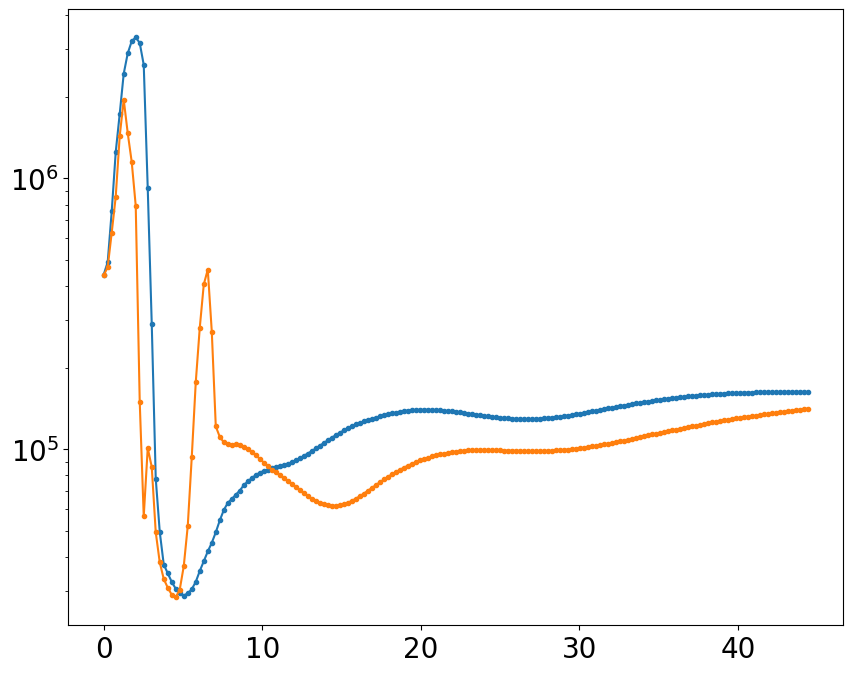

In [10]:
output_dir = f'../fig/20240222_LCGen/'
do_write = True


combs = {}

for rays_res in [16, 32, 64, 128, 256]: #[16, 64, 256]:
    no_xy = (rays_res, rays_res)
    no_xy_txt = 'x'.join([f'{i}' for i in no_xy])
    with open(f"{interm_dir}lcgen.{no_xy_txt}.json", 'r') as f:
        combs[no_xy_txt] = mupl.json_load(f, metadata)


for no_xy_txt in combs.keys():
    comb = combs[no_xy_txt]
    fig, ax = plt.subplots(figsize=(10, 8))
    for job_nickname in ['2md']: #comb.keys(): #['2md']: #['2md', '4md']: #
        for xyzs in ['xyz', 'xzy', 'zyx']: #comb[job_nickname].keys(): #['xzy']: #
            ax.semilogy(
                comb[job_nickname][xyzs]['times_yr'],
                comb[job_nickname][xyzs]['lums_Lsun'],
                '.-',
                label=f"{job_nickname}, +{xyzs[2]}")
    ax.legend()
    ax.set_xlabel('Time / year')
    ax.set_ylabel('Luminosity / $L_\\odot$')
    ax.set_xlim(0., 45.)
    ax.set_ylim(1e4, 1e7) #(1e4, 1e7) #(1e4, 5e8) #
    outfilename_noext = f"{output_dir}LC_dusty_{no_xy_txt}"
    
    # write pdf
    if do_write:
        outfilename = f"{outfilename_noext}.pdf"
        fig.savefig(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")
    
    # write png (with plot title)
    ax.set_title(f"Light curves ({no_xy_txt})")
    if do_write:
        outfilename = f"{outfilename_noext}.png"
        fig.savefig(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Fig saved to {outfilename}.")

In [ ]:
from clmuphantomlib.units_util import DEFAULT_UNITS
(DEFAULT_UNITS['time'] * 280000).to(units.yr)

### Timeit

In [ ]:
xyzs = 'yzx'
xyzs_names_list = [x for x in xyzs]
ans = integrate_along_ray_gridxy(sdf, srcfuncs, rays, xyzs_names_list=xyzs_names_list)
plt.close('all')
plt.imshow(ans.reshape(no_xy))
plt.savefig(f"{output_dir}/heat_I_{job_nickname}_{mpdf.file_index}_{xyzs}.png")
ans

In [ ]:
%timeit integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit integrate_along_ray_gridxy(sdf, srcfuncs, rays, verbose=0)

In [ ]:
%timeit [integrate_along_ray(sdf, ray, srcfuncs)[4] for ray in rays]

### Analyzing error for tau

In [ ]:
# integrating for column kernel
kernel = sdf.kernel
ndim   = 3
q_xy   = 1.
w_col  = kernel.get_column_kernel_func(1000)

q_xy   = 0.

@jit(nopython=True, fastmath=True)
def get_q(*q_is):
    ans = 0
    for q_i in q_is:
        ans += q_i**2
    return ans**0.5


def get_w_q(q_z, q_xy, w, ndim):
    return kernel.w(get_q(q_xy, q_z), ndim)

def my_col(q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    return integrate.quad(lambda q_z: w(get_q(q_xy, q_z), ndim), -w_rad, w_rad)
    
#my_col(q_xy, kernel=kernel, ndim=ndim),  w_col(q_xy, ndim)

In [ ]:


def get_tau_for_single_particle(kappa_m_div_h2:float, q_xy:float, kernel, ndim:int = 3):
    w = kernel.w
    w_rad = kernel.get_radius()
    w_col = kernel.get_column_kernel_func(1000)

    return -np.log(integrate.quad(
        lambda q_z: np.exp(-kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -w_rad, q_z
        )[0]) * w(get_q(q_xy, q_z), ndim),
        -w_rad, w_rad, 
    )[0] / w_col(q_xy, ndim))

kappa_m_div_h2, q_xy = 100., 1.5
dtau  = kappa_m_div_h2*w_col(q_xy, ndim)
w_col = kernel.get_column_kernel_func(1000)
term = 1-np.exp(-dtau)
tau = get_tau_for_single_particle(kappa_m_div_h2=kappa_m_div_h2, q_xy=q_xy, kernel=kernel, ndim=ndim)
print(f"{tau=}", f"{dtau=}", f"frac= {(tau/dtau)*100:.2f}%", '', sep='\n')
print(
    f"{np.exp(-tau    )*term=}",
    f"{np.exp(-tau    )*dtau=}",
    f"{np.exp(-0.     )*term=}",
    f"{np.exp(-dtau/2.)*term=}",
    f"{np.exp(-dtau   )*term=}",
    sep='\n')

In [ ]:
w_col

In [ ]:
kappa_m_div_h2 * integrate.quad(
            lambda q_z1: w(get_q(q_xy, q_z1), ndim),
            -2., 1.)[0]

In [ ]:
help(kernel.get_column_kernel_func)

### In Writing

#### Getting LC

In [ ]:
do_extrap : bool = False
T_cond_oxy: units.Quantity = 1450 * units.K
kappa_gas : units.Quantity = 2e-4*(units.cm**2/units.g)
job_name    = '../dustystar/clmu_dustybase/relax'#job_profile['job_name']
file_index  = 0
params      = JOB_PROFILES_DICT['2md']['params'] #job_profile['params']


mpdf = mupl.MyPhantomDataFrames()
mpdf.read(job_name, file_index, reset_xyz_by='CoM', calc_params=['vr', 'R1'], verbose=verbose)
sdf  = mpdf.data['gas']
eos = mupl.get_eos(ieos=10, params=params, settings=settings)
eos_opacity = EoS_MESA_opacity(params, settings)
sdf['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
del sdf['Tdust']
kappa_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=do_extrap)
#mpdf.data['gas']['kappa'] = np.where(
#    mpdf.data['gas']['T'] < T_cond_oxy,
#    kappa_gas.to_value( mpdf.units['opacity']),
#    kappa_mesa.to_value(mpdf.units['opacity']),
#)
mpdf.data['gas']['kappa'] = kappa_mesa.to_value(mpdf.units['opacity'])

In [ ]:
# testing ray loc distribution
rays, areas, dXs = get_xy_grids_of_rays(sdf, no_xy=(32, 32), frac_contained=100., use_adaptive_grid=False)
plt.plot(rays[:, 0, 0], rays[:, 0, 1], '.')

In [ ]:
hs = dats
hs

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)
srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi #/ (4 * pi)
#srcfuncs = np.array(sdf['h'])


rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
plt.hist(np.log10(mpdf.get_val('T').value))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.to_value(units.Lsun) / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
#ax.set_ylabel('$\\triangle L$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_relax_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=np.array(lums).reshape(no_xy))
fig.colorbar(s, label='')# {I / (4 \pi L_\\odot / R_\\odot^2)}$')
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Rsun')
ax.set_title(f"Integrated  specfic intensity contribution per ray\nbefore relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dlum_relax_res{mpdf.params['nparttot']:.2e}.png")

.

#### Trying the same thing with after-relaxed higher resolution model

.

In [ ]:
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
print(f"{mpdf.get_time() = }")

In [ ]:
mpdf.data['gas']['T'] = eos.get_temp(rho=mpdf.get_val('rho'), u=mpdf.get_val('u')).to_value(mpdf.units['temp'])
mpdf.data['gas'][['Tdust', 'temperature', 'T']]

In [ ]:
#no_xy=(17, 17)
no_xy=(32, 32)

srcfuncs = np.array(mpdf.const['sigma_sb'] * sdf['T']**4) / pi
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
dats = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
lums = (4 * pi * dats * areas * mpdf.units['lum']).to(units.solLum)
lum  = lums.sum()
print(f"{lum:.2e}")
lum

In [ ]:
srcfuncs = np.array(sdf['h'])
rays, areas, _ = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=100., use_adaptive_grid=False)
hs   = integrate_along_ray_grid(sdf, srcfuncs, rays, verbose=0)
hs  *= units.Rsun
hs

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.loglog(np.sqrt(rays[:, 0, 0]**2+rays[:, 0, 1]**2), lums.value / areas, '.')
ax.set_xlabel('$R_\\mathrm{CoM}$ / Rsun')
ax.set_ylabel('$I \\, / \\, (4 \pi L_\\odot / R_\\odot^2)$')
ax.set_title(f"Integrated luminosity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/scatter_dlum-vs-RCoM_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(lums / areas).reshape(no_xy), origin='lower')
fig.colorbar(s, label='${I / (4 \pi L_\\odot / R_\\odot^2)}$') #\\log_{10} 
#ax.set_xlabel('$x$')# / Rsun')
#ax.set_ylabel('$y$')# / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_dI_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 8))
#s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(lums / areas).reshape(no_xy))) #np.log10
s = ax.imshow(np.array(hs).reshape(no_xy), origin='lower')
fig.colorbar(s, label='$h \\, / \\, R_\\odot$') #\\log_{10} 
#ax.set_xlabel('$x$ / Rsun')
#ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated smoothing length per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
s = ax.scatter(rays[:, 0, 0], rays[:, 0, 1], c=(np.array(hs).reshape(no_xy))) #np.log10
fig.colorbar(s, label='${h / R_\\odot}$') #\\log_{10} 
ax.set_xlabel('$x$ / Rsun')
ax.set_ylabel('$y$ / Lsun')
ax.set_title(f"Integrated specfic intensity contribution per ray\nafter relaxation, resolution={mpdf.params['nparttot']:.2e}")
fig.savefig(f"../fig/heat_h_light_res{mpdf.params['nparttot']:.2e}.png")

In [ ]:
help(ax.imshow)

In [ ]:
7534.8/10246.54

In [ ]:
f"{lum:.2e}"

In [ ]:
get_xy_grids_of_rays

In [ ]:
plt.imshow(np.array(lums).reshape(no_xy))

In [ ]:
np.max(mpdf.data['gas']['h'])

In [ ]:
mpdf.data['gas']['u']

## IGNORE BELOW
#### NOT YET FINISHED ADAPTING FROM THE OLD SCRIPTS

### Getting initial MESA profile vs relaxed phantom profile

In [ ]:
def plot_stuff(stuff_dict: dict, x_name: str, y_name: str, mpdf, job_profile, xlim: tuple[float, float]=(1., 1.e3)):
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.loglog(stuff_dict[x_name], stuff_dict[y_name], '.')
    ax.set_xlabel(f"{x_name} / {stuff_dict[x_name].unit.to_string('latex_inline')}")
    ax.set_ylabel(f"{y_name} / {stuff_dict[y_name].unit.to_string('latex_inline')}")
    ax.text(
        0.98, 0.98, f"Time = {mpdf.get_time()}",
        ha = 'right', va = 'top', transform=ax.transAxes,
    )
    ax.set_title(f"scatter plot of all particles\n{job_profile['plot_title_suffix']}")
    ax.set_xlim(xlim)
    return fig, ax

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T']**4 #/ (4 * pi)

In [ ]:
# reading mesa data
mesa_data = np.loadtxt(
    '../dustystar/AGB_th.data', skiprows=6,
    usecols=(2, 3, 4, 9, 10, 11, 12, 19),
    dtype=[
        ('log10_R1', np.double),
        ('log10_T', np.double),
        ('log10_rho', np.double),
        ('R1_cm', np.double),
        ('mass_g', np.double),
        ('temp', np.double),
        ('rho', np.double),
        ('lum', np.double)]
)
stuff_mesa = {
    'R1': (mesa_data['R1_cm'] * units.cm).to(units.Rsun),
    'T' : mesa_data['temp'] * units.K,
    'lum' : mesa_data['lum'] * units.Lsun,
    'rho' : mesa_data['rho'] * (units.g/units.cm**3)
}
del mesa_data 
stuff_mesa['L'    ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T']**4)).to(units.Lsun)
stuff_mesa['kappa'] = eos_opacity.get_kappa(rho=stuff_mesa['rho'], T=stuff_mesa['T'])
#stuff_mesa['wtf'  ] = (4 * pi * stuff_mesa['R1']**2 * (const.sigma_sb * stuff_mesa['T'].value**2.5 * units.K**4)).to(units.Lsun)
# below should be one, but it is not. Not sure why
L_0 = stuff_mesa['lum'][0]
R_0 = stuff_mesa[ 'R1'][0]
stuff_mesa['factor'] = (stuff_mesa['R1'].cgs**2 * (
    R_0**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs
stuff_mesa['wtf'  ]  = (integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2)[::-1].cgs, stuff_mesa['R1'][::-1].cgs, initial=0
    )*units.cm**(-2))[::-1]
stuff_mesa['test' ]  = (stuff_mesa['R1'].cgs[0]**2 * (
    stuff_mesa['R1'].cgs**(-2) - integrate.cumtrapz(
        (stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs, stuff_mesa['R1'].cgs, initial=0
    )*units.cm**(-2))).cgs

In [ ]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['rho'  ] = mpdf.get_val('rho').cgs

In [ ]:
stuff_rad = stuff.copy()
stuff_rad_indices = ()

In [ ]:
plt.close('all')
for what in ['T', 'rho', 'kappa']:
    fig, ax = plot_stuff(stuff, 'R1', what, mpdf, {'plot_title_suffix' : job_nickname + " - phantom vs mesa"})
    ax.loglog(stuff_mesa['R1'], stuff_mesa[what], '.', label='mesa')
    ax.axvline(x=stuff_mesa['R1'][0].value, color='grey', linestyle='dashed')
    ax.legend(['phantom', 'mesa'], loc='lower left')
    fig.savefig(f"{output_dir}/phantom-vs-mesa_2md_{what}-R1.png")
    plt.show(fig)

In [ ]:
np.log(678e89)

In [ ]:
%timeit np.log(123e34) - 211.44922056441047

In [ ]:
%timeit 123e34 / np.exp(211.44922056441047)

In [ ]:
(450*units.au).to_value(mpdf.units['dist'])

In [ ]:
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity, reset_xyz_by='R1')
mpdf.calc_sdf_params(['R1'])
sdf  = mpdf.data['gas']
inds = (sdf['R1'] > (450*units.au).to_value(mpdf.units['dist']))
(np.sum(sdf[inds]['m'])*mpdf.units['mass']).to(units.Msun)

In [ ]:
mpdf.get_val('kappa').cgs

In [ ]:
stuff = {}
stuff['kappa'] = mpdf.get_val('kappa').cgs
stuff['R1'   ] = mpdf.get_val('R1').to(units.Rsun)
stuff['T'    ] = mpdf.get_val('T').to(units.K)
stuff['L'    ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T']**4)).to(units.Lsun)
stuff['wtf'  ] = (4 * pi * stuff['R1']**2 * (const.sigma_sb * stuff['T'].value**2.5 * units.K**4)).to(units.Lsun)
stuff['rhokappa'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs
stuff['rhokappaR'] = mpdf.get_val('rho').cgs * mpdf.get_val('kappa').cgs * mpdf.get_val('R1').cgs

In [ ]:
np.max(stuff['rhokappaR'] / (stuff['rhokappaR'] - 2) - 1)

In [ ]:
np.min(stuff['rhokappaR'] )

In [ ]:
(stuff_mesa['kappa'] * stuff_mesa['rho'] / stuff_mesa['R1']**2).cgs

In [ ]:
(L_0 / R_0**2).cgs

In [ ]:
plt.plot(stuff_mesa['R1'], stuff_mesa['factor'])
plt.ylim(0., 2.)

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'factor', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'wtf', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'lum', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
stuff_mesa['T']

In [ ]:
eos_opacity.get_kappa(stuff_mesa)

In [ ]:
stuff_mesa['lum'][:10]

In [ ]:
stuff_mesa['L'][0], stuff_mesa['lum'][0]

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'T', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff_mesa, 'R1', 'L', mpdf, {'plot_title_suffix' : 'mesa profile'}, xlim=None)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
stuff_mesa['R1'][::100]

In [ ]:
# phantom plots

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'rhokappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'kappa', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'T', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
fig, ax = plot_stuff(stuff, 'R1', 'L', mpdf, job_profile)
fig.savefig(f"{output_dir}/temp.png")

In [ ]:
mpdf.plot_render()

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17), frac_contained=99.99)
rays

In [ ]:
no_xy=(17, 17)
rays, areas = get_xy_grids_of_rays(sdf, no_xy=no_xy, frac_contained=99.99)
lums = []
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lums.append(dat * area) #* 4 * pi 
    if len(lums)%10 == 0:
        print(len(lums))

lums = (lums * mpdf.units['lum']).to(units.solLum)
lum = lums.sum()
lum

In [ ]:
# Test
job_nickname= '2md'
job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf = mpdf_read(job_name, 0, eos_opacity)
sdf  = mpdf.data['gas']
ray = mupl.get_rays(mpdf.data['sink'][['x', 'y', 'z']].iloc[0], np.array([0., 0., 1.]))
srcfuncs = mpdf.const['sigma_sb'] * sdf['T'] * sdf['T']**4 #/ (4 * pi)

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(17, 17))
lum = 0.
lums = []
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi
    lums.append(dat*area)
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)/1e6

In [ ]:
sdf['R0'] = (sdf['x']**2 + sdf['y']**2 + sdf['z']**2)**0.5
sdf['kappa_cgs'] = mupl.units_util.get_val_in_unit(sdf['kappa'], mpdf.units['opacity'], units.cm**2/units.g)
sdf.iloc[np.array(sdf['R0'] > 380)]

In [ ]:
mpdf.plot_render()

In [ ]:
rays, areas = get_xy_grids_of_rays(sdf, no_xy=(16, 16))
lum = 0.
i = 0
for ray, area in zip(rays, areas):
    ans = integrate_along_ray(sdf, ray, srcfuncs)
    pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
    lum += dat * area #* 4 * pi 
    if i%50 == 0:
        print(i)
    i += 1

lum *= mpdf.units['lum']
lum.to(units.solLum)

In [ ]:
ans = integrate_along_ray(sdf, ray, srcfuncs)
pts_order, pts_on_ray, dtaus_ordered, taus_ordered, dat, _, dat_bwd_inc = ans
dat

In [ ]:

np.where(dat_bwd_inc / dat > 1e-7), dat_bwd_inc.shape

In [ ]:
def get_ph_vals(
    vals_names: list,
    mpdf: MyPhantomDataFrames,
    eos: mupl.eos_base.EoS_Base,
    rays_unit_vecs : np.ndarray, # (no_ray, 3)-shaped
    verbose: int,
):
    sdf_all = mpdf.data['gas']
    hs = np.array(sdf_all['h'])
    pts = np.array(sdf_all[['x', 'y', 'z']])    # (npart, 3)-shaped array
    kernel_radius = sdf_all.kernel.get_radius()

    plane_orig_vec = np.array(mpdf.data['sink'][['x', 'y', 'z']].iloc[0])

    # random direction in the sphere
    #rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
    no_ray = len(rays_unit_vecs)
    
    vals_dict = {
        'tau_dust': np.full(no_ray, np.nan),
        'inner_dust_shell_rad': np.full(no_ray, np.nan) * mpdf.units['dist'],
    }
    
    for iray, ray_unit_vec in enumerate(rays_unit_vecs):
        ray = np.array([
            plane_orig_vec,
            plane_orig_vec + ray_unit_vec,
        ])
        
        pts_on_ray = mupl.get_closest_pt_on_line(pts, ray)
        sdf_selected_indices = (np.sum((pts - pts_on_ray)**2, axis=-1) <= (kernel_radius * hs)**2)
        sdf = sdf_all.iloc[sdf_selected_indices]
        
        pts_on_ray, dtaus, pts_order = get_optical_depth_by_ray_tracing_3D(sdf, ray)
        photosphere, waypts_list = get_photosphere_on_ray(
            pts_on_ray, dtaus, pts_order, sdf, ray,
            calc_params = vals_names,
            eos = eos,
            sdf_units = mpdf.units,
            photosphere_tau = PHOTOSPHERE_TAU,
            return_as_quantity=True,
            verbose = 1 if is_verbose(verbose, 'err') else 0,
        )
        for val_name in vals_names:
            if iray == 0:
                # init
                vals_dict[val_name] = np.full((*photosphere[val_name].shape, no_ray), np.nan)
                if isinstance(photosphere[val_name], units.quantity.Quantity):
                    vals_dict[val_name] *= photosphere[val_name].unit
            # save value
            vals_dict[val_name][iray] = photosphere[val_name]
            
            kappa_tol = 1e-7*(units.cm**2/units.g)
            kappa_tol_val = kappa_tol.to_value(mpdf.units['opacity'])
            pts_waypts_t = np.sum((pts_on_ray - ray[0]) * ray_unit_vec, axis=-1) # the higher, the more on the pt2 side (observer)
            # find the furtherest dust-containing particle on the observer's side
            last_dust_part_ordered_indices = np.where(np.logical_and(
                pts_waypts_t[pts_order] > 0,    # condition 1: on the observer's side (i.e. don't be further than the sink)
                sdf.iloc[pts_order]['kappa_dust'] > kappa_tol_val,    # condition 2: dust-containing
            ))[0]
            if len(last_dust_part_ordered_indices):
                # found the dust shell!
                last_dust_part_ordered_ind = last_dust_part_ordered_indices[-1]
                vals_dict['tau_dust'][iray] = np.sum(dtaus[pts_order][:last_dust_part_ordered_ind])
                vals_dict['inner_dust_shell_rad'][iray] = mupl.set_as_quantity(
                    pts_waypts_t[pts_order][last_dust_part_ordered_ind], mpdf.units['dist'])
    vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
    vals_dict['ray_unit_vec'] = rays_unit_vecs
    
    return vals_dict

In [ ]:
def get_photosphere_vals_rand_samples(
    job_nickname: str,
    file_index: int,
    no_ray: int,
    vals_names: list = ['R1', 'T'],
    cos_theta_sample_no: int|None = None,
    mpdf: MyPhantomDataFrames = None,
    verbose: int = 3,
) -> dict:
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos = job_profile['ieos']
    eos  = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    mpdf = mpdf_read(
        job_name, file_index, eos_opacity, mpdf,
        kappa_gas = 2e-4*(units.cm**2/units.g) if file_index != 0 else 0.*(units.cm**2/units.g),
        verbose=verbose)

    if cos_theta_sample_no is None:

        rays_unit_vecs = get_rand_rays_unit_vec(no_ray)
        vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
    
        if is_verbose(verbose, 'note'):
            say('note', f'{mpdf.get_filename()}', verbose,
                *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
            )
    else:
        # A fixed amount of rays per cos_theta interval will be generated
        #cos_theta_sample_no = 2
        ray_per_cos_theta = int(no_ray/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)
        vals_by_cos_thetas = []
    
        for i, cos_theta_mid in enumerate(cos_thetas):
            rays_unit_vecs = get_rand_rays_unit_vec(ray_per_cos_theta, cos_theta_mid, cos_theta_delta)
            vals_dict = get_ph_vals(vals_names, mpdf, eos, rays_unit_vecs, verbose=verbose)
            #vals_dict['cos_theta'] = rays_unit_vecs[:, 2]
            vals_by_cos_thetas.append(vals_dict)
        
            if is_verbose(verbose, 'note'):
                say('note', f'cos_theta_mid = {cos_theta_mid}', verbose,
                    *[f'{val_name} = {np.average(vals_dict[val_name])} +/- {np.std(vals_dict[val_name])}' for val_name in vals_names]
                )
        
        vals_dict = { key: np.concatenate([data[key] for data in vals_by_cos_thetas]) for key in vals_by_cos_thetas[0].keys()}

    return vals_dict

.

## Main

.


In [ ]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    for job_nickname in ['2md']:  # '2md', 
        for file_index in [4800, 6400]: # [0, 2000, 8000, 17600]
            vals_dict = get_photosphere_vals_rand_samples(
                job_nickname, file_index, no_ray, vals_names=['R1', 'T', 'rho', 'kappa', 'nneigh', 'vr'], cos_theta_sample_no=None, mpdf=mpdf)
            with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'w') as f:
                json_dump(vals_dict, f, metadata)
    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")